# Statistical inference of stock returns with linear regression

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import pandas as pd

from statsmodels.api import OLS, add_constant, graphics
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Load Data

In [4]:
with pd.HDFStore('data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))

### Select Investment Universe

In [5]:
data = data[data.dollar_vol_rank<100]

In [6]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 109669 entries, ('AAL', Timestamp('2013-07-03 00:00:00')) to ('UAL', Timestamp('2017-11-20 00:00:00'))
Data columns (total 65 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   volume                 109669 non-null  float64
 1   dollar_vol             109669 non-null  float64
 2   dollar_vol_1m          109669 non-null  float64
 3   dollar_vol_rank        109669 non-null  float64
 4   rsi                    109669 non-null  float64
 5   bb_high                109669 non-null  float64
 6   bb_low                 109669 non-null  float64
 7   atr                    109669 non-null  float64
 8   macd                   109669 non-null  float64
 9   return_1d              109669 non-null  float64
 10  return_5d              109669 non-null  float64
 11  return_10d             109669 non-null  float64
 12  return_21d             109669 non-null  float64
 13  return_42d    

### Create Model Data

In [7]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)

## Explore Data

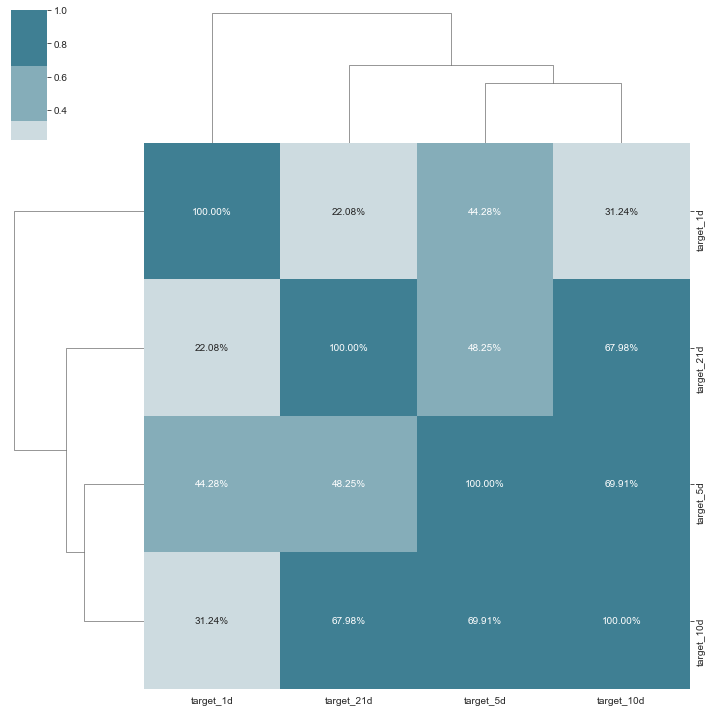

In [8]:
sns.clustermap(y.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0, annot=True, fmt='.2%');

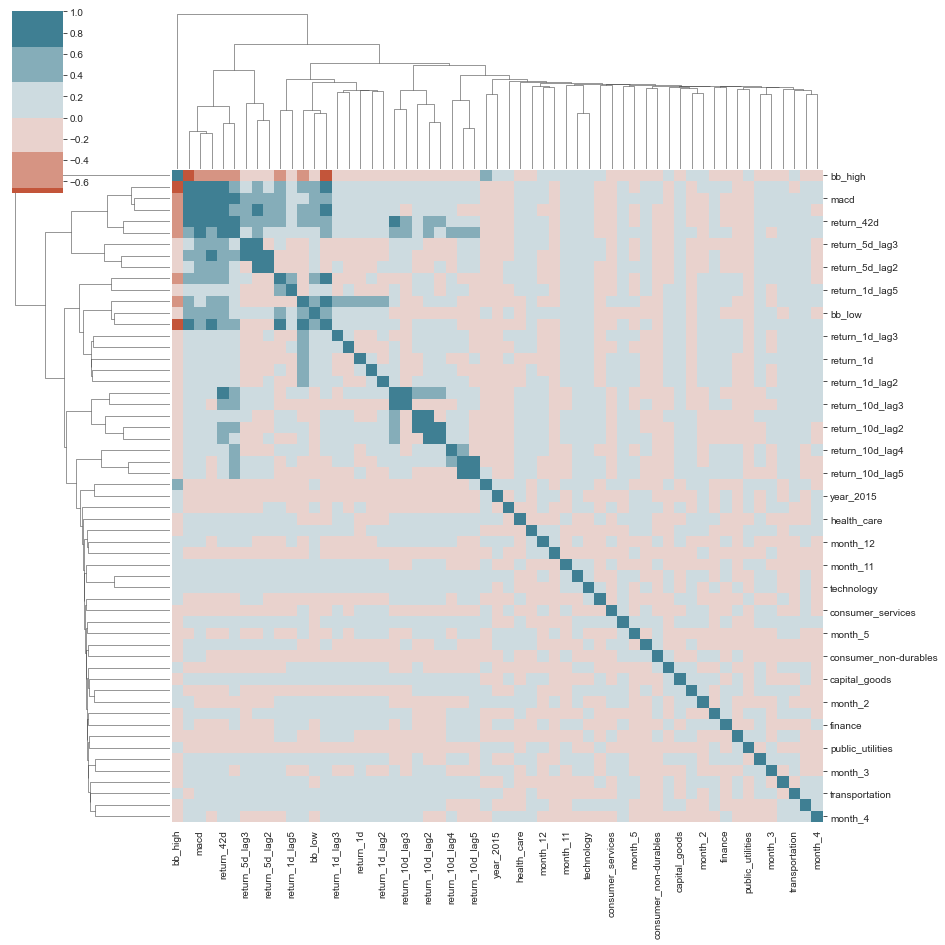

In [9]:
sns.clustermap(X.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0);
plt.gcf().set_size_inches((14, 14))

In [10]:
corr_mat = X.corr().stack().reset_index()
corr_mat.columns=['var1', 'var2', 'corr']
corr_mat = corr_mat[corr_mat.var1!=corr_mat.var2].sort_values(by='corr', ascending=False)

In [11]:
corr_mat.head().append(corr_mat.tail())

,var1,var2,corr
637,return_63d,return_42d,0.830927
581,return_42d,return_63d,0.830927
286,macd,rsi,0.817216
62,rsi,macd,0.817216
518,return_21d,macd,0.807328
515,return_21d,bb_high,-0.637176
122,bb_high,return_10d,-0.699278
458,return_10d,bb_high,-0.699278
115,bb_high,rsi,-0.708962
59,rsi,bb_high,-0.708962


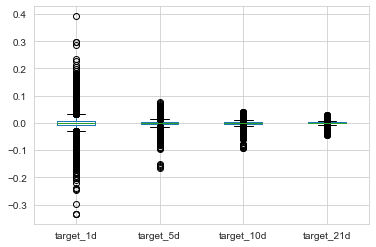

In [12]:
y.boxplot();

## Linear Regression for Statistical Inference: OLS with statsmodels

### Ticker-wise standardization

`statsmodels` warns of high design matrix condition numbers. This can arise when the variables are not standardized and the Eigenvalues differ due to scaling. The following step avoids this warning.

In [13]:
sectors = X.iloc[:, -10:]
X = (X.drop(sectors.columns, axis=1)
     .groupby(level='ticker')
     .transform(lambda x: (x - x.mean()) / x.std())
    .join(sectors)
    .fillna(0))

### 1-Day Returns

In [14]:
target = 'target_1d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:              target_1d   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     17.33
Date:                Mon, 17 May 2021   Prob (F-statistic):          4.54e-169
Time:                        12:07:05   Log-Likelihood:             2.8890e+05
No. Observations:              109669   AIC:                        -5.777e+05
Df Residuals:                  109611   BIC:                        -5.771e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -6.91e-

### 5-Day Returns

In [15]:
target = 'target_5d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:              target_5d   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     61.22
Date:                Mon, 17 May 2021   Prob (F-statistic):               0.00
Time:                        12:07:05   Log-Likelihood:             3.7922e+05
No. Observations:              109669   AIC:                        -7.583e+05
Df Residuals:                  109611   BIC:                        -7.578e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

#### Obtain the residuals

In [16]:
preds = trained_model.predict(add_constant(X))
residuals = y[target] - preds

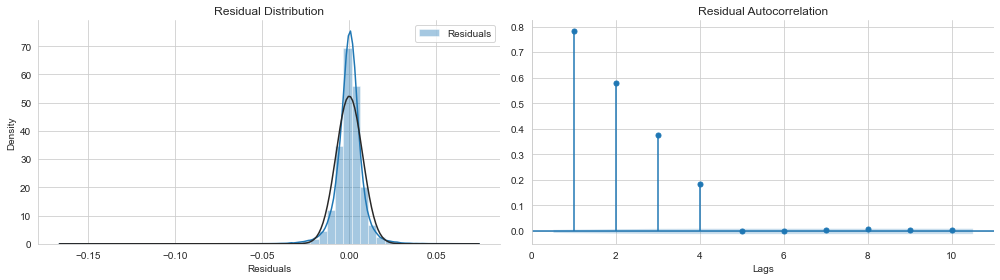

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();

### 10-Day Returns

In [18]:
target = 'target_10d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:             target_10d   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     89.32
Date:                Mon, 17 May 2021   Prob (F-statistic):               0.00
Time:                        12:07:08   Log-Likelihood:             4.1965e+05
No. Observations:              109669   AIC:                        -8.392e+05
Df Residuals:                  109611   BIC:                        -8.386e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

### Monthly Returns

In [19]:
target = 'target_21d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:             target_21d   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     131.7
Date:                Mon, 17 May 2021   Prob (F-statistic):               0.00
Time:                        12:07:08   Log-Likelihood:             4.6303e+05
No. Observations:              109669   AIC:                        -9.259e+05
Df Residuals:                  109611   BIC:                        -9.254e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00